**FERGD**

Pruebas de *mecánica cuántica* básica tomadas de
https://ben.land/post/2022/03/09/quantum-mechanics-simulation/

Editadas por FERGD (sumé ploteo de $<x>$)

## I. Funciones

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

x = np.linspace(-10,10,5000)
deltax = x[1]-x[0]

In [3]:
def norm(phi):
    norm = np.sum(np.square(np.abs(phi)))*deltax
    return phi/np.sqrt(norm)

def complex_plot(x,y,prob=True, plot_mean=False, **kwargs):
    real = np.real(y)
    imag = np.imag(y)
    a,*_ = plt.plot(x,real,label='Re',**kwargs, alpha = 0.3)
    b,*_ = plt.plot(x,imag,label='Im',**kwargs, alpha = 0.3)
    plt.xlim(-2,2)
    if prob:
        if plot_mean:
            expectation = np.sum(np.multiply(x , np.abs(y)))*deltax   # Commentitutti
            p,*_ = plt.plot(x,np.abs(y),label='$\sqrt{P}$')
            l = plt.axvline(x = expectation, color = 'C7', linestyle = 'dashed',  label = '$<x>$')
            return a,b,p,l
        else:
            p,*_ = plt.plot(x,np.abs(y),label='$\sqrt{P}$')
            return a,b,p
    else:
        return a,b
    
def wave_packet(pos=0,mom=0,sigma=0.2):
    return norm(np.exp(-1j*mom*x)*np.exp(-np.square(x-pos)/sigma/sigma,dtype=complex))

In [4]:
def d_dxdx(phi,x=x):
    dphi_dxdx = -2*phi
    dphi_dxdx[:-1] += phi[1:]
    dphi_dxdx[1:] += phi[:-1]
    return dphi_dxdx/deltax

def d_dt(phi,h=1,m=100,V=0):
    return 1j*h/2/m * d_dxdx(phi) - 1j*V*phi/h

def euler(phi, dt, **kwargs):
    return phi + dt * d_dt(phi, **kwargs)

def rk4(phi, dt, **kwargs):
    k1 = d_dt(phi, **kwargs)
    k2 = d_dt(phi+dt/2*k1, **kwargs)
    k3 = d_dt(phi+dt/2*k2, **kwargs)
    k4 = d_dt(phi+dt*k3, **kwargs)
    return phi + dt/6*(k1+2*k2+2*k3+k4)

Funcion que aplica metodos de aproximacion a la ecuacion de shroedinger

In [5]:
def simulate(phi_sim, 
             method='rk4', 
             V=0, 
             steps=100000, 
             dt=1e-1, 
             condition=None, 
             normalize=True,
             save_every=100):
    simulation_steps = [np.copy(phi_sim)]
    for i in range(steps):
        if method == 'euler':
            phi_sim = euler(phi_sim,dt,V=V)
        elif method == 'rk4':
            phi_sim = rk4(phi_sim,dt,V=V)
        else:
            raise Exception(f'Unknown method {method}')
        if condition:
            phi_sim = condition(phi_sim)
        if normalize:
            phi_sim = norm(phi_sim)
        if save_every is not None and (i+1) % save_every == 0:
            simulation_steps.append(np.copy(phi_sim))
    return simulation_steps

Generador de animaciones

In [6]:


def animate(simulation_steps,init_func=None, plot_mean=False):
    fig = plt.figure()
    if plot_mean:
        re,im,prob,l = complex_plot(x,simulation_steps[0], plot_mean=plot_mean)
    else:
        re,im,prob   = complex_plot(x,simulation_steps[0], plot_mean=plot_mean)
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    if init_func:
        init_func()
    plt.legend()
    def animate(frame):
        if plot_mean:
            prob.set_data((x, np.abs(simulation_steps[frame])))
            re.set_data((x, np.real(simulation_steps[frame])))
            im.set_data((x, np.imag(simulation_steps[frame])))
            l.set_xdata( np.sum(np.multiply(x , np.abs(simulation_steps[frame])))*deltax )
            return prob,re,im,l
        else:
            prob.set_data((x, np.abs(simulation_steps[frame])))
            re.set_data((x, np.real(simulation_steps[frame])))
            im.set_data((x, np.imag(simulation_steps[frame])))
            return prob,re,im
    anim = FuncAnimation(fig, animate, frames=int(len(simulation_steps)), interval=50)
    plt.close()

    return anim

## II. Particula Libre

In [7]:
sim_free = simulate(wave_packet(),steps=200000,save_every=2000)
anim = animate(sim_free)
HTML(anim.to_html5_video())

## III. Particula en una caja de potencial infinito

In [99]:
box_potential = np.where((x>-2)&(x<2),0,1)
sim_box_mom = simulate(wave_packet(mom=10, sigma=0.1),V=box_potential,steps=200000,save_every=1000)
def box_init():
    plt.gcf().axes[0].axvspan(2, 3, alpha=0.2, color='red')
    plt.gcf().axes[0].axvspan(-3, -2, alpha=0.2, color='red')
    plt.xlim(-3,3)
    plt.ylim(-3,3)

anim2 = animate(sim_box_mom, init_func=box_init)
HTML(anim2.to_html5_video())

Primer Eigenestado del Hamiltoniano

In [100]:
sim_box_eigen = simulate(wave_packet(mom=10),dt=-1e-1j,V=box_potential,steps=150000,save_every=1000)
anim2bis = animate(sim_box_eigen,init_func=box_init)
HTML(anim2bis.to_html5_video())

## IV. Particula contra una barrera de potencial acotado (tunneling)

In [87]:
barrier_weak_potential = np.where((x>1.4)&(x<1.6),3.5e-2,0)
sim_barrier_mom = simulate(wave_packet(mom=-35),V=barrier_weak_potential,steps=50000,save_every=250)

def barrier_init():
    plt.gcf().axes[0].axvspan(1.4, 1.6, alpha=0.2, color='orange')
    plt.xlim(-2,4)
    plt.ylim(-3,3)

anim3 = animate(sim_barrier_mom,init_func=barrier_init)
HTML(anim3.to_html5_video())

## V. Potencial cuadratico

In [88]:
quadratic_potential = 1e-2*np.square(x)
sim_quadratic_potential = simulate(wave_packet(mom=10),V=quadratic_potential,steps=100000,save_every=1000)

def quadratic_init():
    plt.fill_between(x,(np.square(x)-3),-3,color='orange',alpha=0.2)
    plt.xlim(-3,3)
    plt.ylim(-3,3)

anim4 = animate(sim_quadratic_potential,init_func=quadratic_init, plot_mean=True)
HTML(anim4.to_html5_video())

Primer EigenEstado (evoluciona en tiempo imaginario y renormaliza y quedan solamente los eigen de menor energia)

In [89]:
sim_quad_0 = simulate(wave_packet(mom=10),dt=-1e-1j,V=quadratic_potential,steps=200000,save_every=1000)
anim5 = animate(sim_quad_0,init_func=quadratic_init)
HTML(anim5.to_html5_video())

(<matplotlib.lines.Line2D at 0x7fe2c91775b0>,
 <matplotlib.lines.Line2D at 0x7fe2c9177b20>)

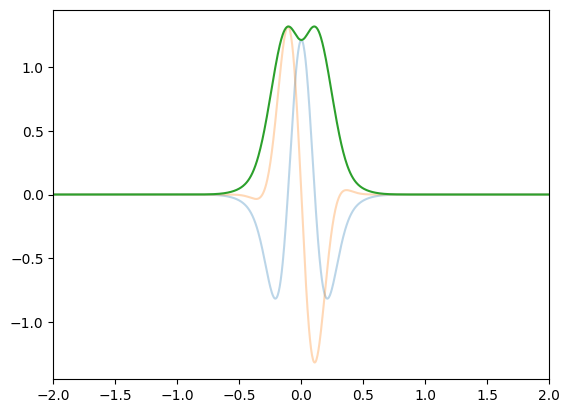

In [90]:
psi = wave_packet(mom=10)
phi_0 = sim_quad_0[-1]
Psi_1 = psi - np.sum(np.conjugate(phi_0)*psi)*deltax*phi_0
complex_plot(x,Psi_1)

Segundo eigenEstado

In [91]:
def orthogonal_to(states):
    def orthogonalize(phi):
        for state in states:
            phi = phi - np.sum(np.conjugate(state)*phi)*deltax*state
        return phi
    return orthogonalize

sim_quad_1 = simulate(psi, dt=-1e-1j, condition=orthogonal_to([phi_0]), V=quadratic_potential, steps=200000, save_every=1000)
anim6 = animate(sim_quad_1,init_func=quadratic_init)
HTML(anim6.to_html5_video())

Segundo EigenEstado - forma y evolucion (solo cambia la fase!)

(<matplotlib.lines.Line2D at 0x7fe2990405e0>,
 <matplotlib.lines.Line2D at 0x7fe2b99e04f0>)

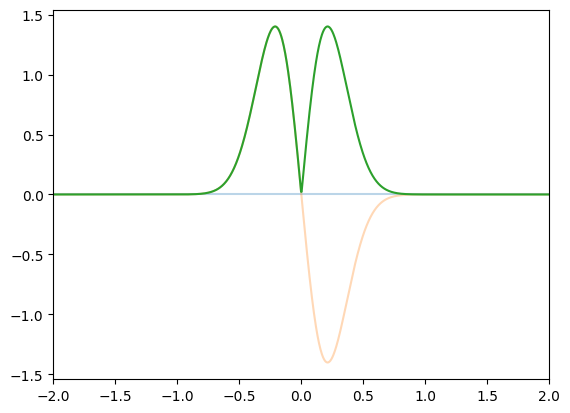

In [92]:
phi_1 = sim_quad_1[-1]
complex_plot(x,phi_1)

In [93]:
sim_quadratic_potential = simulate(phi_1,V=quadratic_potential,steps=40000,save_every=1000)
anim7 = animate(sim_quadratic_potential,init_func=quadratic_init)
HTML(anim7.to_html5_video())

Tercer Eigenestado

In [94]:
sim_quad_2 = simulate(psi, dt=-1e-1j, condition=orthogonal_to([phi_0, phi_1]), V=quadratic_potential, steps=100000, save_every=1000)
anim8 = animate(sim_quad_2,init_func=quadratic_init)
HTML(anim8.to_html5_video())

Suma de primeros dos Eigenestados

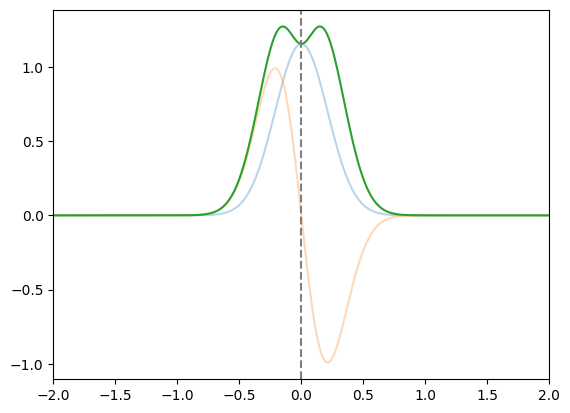

In [95]:
phi_1_2 = (1 / (2 **(1/2))) * phi_0 + (1 / (2 **(1/2))) * phi_1
a,b,prob,l = complex_plot(x,phi_1_2, plot_mean=True)

Vibración de diferencia entre primer y segundo modo ( = energía del fotón emitido/absorbido entre un modo y otro)

In [96]:
sim_quad_3 = simulate(phi_1_2, V=quadratic_potential, steps=100000, save_every=1000)
anim9 = animate(sim_quad_3,init_func=quadratic_init, plot_mean=True)
HTML(anim9.to_html5_video())